In [2]:
!python src/main.py --config experiments/train_ichiro_new.yaml --output_dir ichiro_training_new --dataset_path dataset/hrp/

BATCH_SIZE: 16
DATASET:
  FLIP: 0.5
  INPUT_SIZE: [384, 384]
  MAX_NUM_DETECTIONS: 10
  MEAN: (0.485, 0.456, 0.406)
  NUM_KEYPOINTS: 6
  NUM_LIMBS: 5
  OUTPUT_SIZE: [192, 192]
  ROTATION: 40
  SCALE: [0.5, 1.5]
  SIGMA: 2.0
  STD: (0.229, 0.224, 0.225)
  TEST: val_ichiro_new
  TRAIN: train_ichiro_new
  TRANSLATE: 0.4
DEVICE: cuda
LOSS:
  USE_WEIGHT: True
MODE: hm
MODEL:
  BACKBONE: resnet18
  FINAL_KERNEL: 3
  NUM_SCALES: 2
  PRETRAINED: True
NUM_EPOCHS: 50
NUM_WORKERS: 2
PIN_MEMORY: False
PRINT_FREQ: 100
SEED: 42
TEST:
  DETECTION_THRESHOLD: 0.1
  KEEP_RATIO: True
  LIMB:
    CONNECTION_RATIO: 0.8
    CONNECTION_TOLERANCE: 0.7
    DELETE_SHARED_PARTS: False
    IGNORE_FEW_PARTS: False
    LENGTH_RATE: 16
    MIN_MEAN_SCORE: 0.2
    MIN_NUM_CONNECTED_PARTS: 3
    NUM_MIDPOINTS: 20
    THRESHOLD: 0.05
  NMS_KERNEL: 3
  PROJECT: True
TRAIN:
  LR: 0.0001
  LR_FACTOR: 0.0
  LR_STEPS: []
  MOMENTUM: 0.0
  OPTIMIZER: adamw
  WD: 0.0001
/usr/local/lib/python3.10/dist-packages/torchvision/mode

In [50]:
from SimplePoseNet import SimplePoseNet

model = SimplePoseNet(nof_joints=6, checkpoint_path='ichiro_training_new/checkpoint.pth')
keypoint_coordinat = model.predict('dataset/hrp/images/output3_37.jpg')
keypoint_coordinat

[(396, 56), (384, 448), (0, 0), (476, 216), (320, 392), (408, 396)]

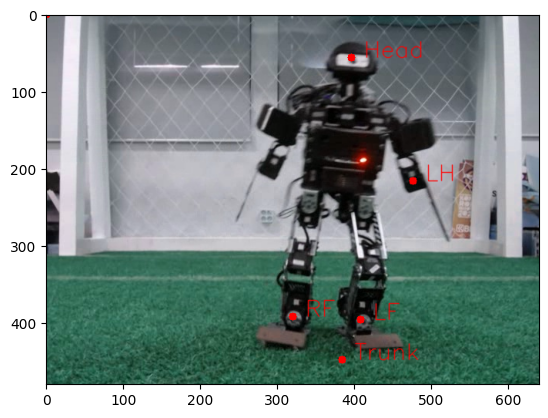

In [51]:
import cv2
import matplotlib.pyplot as plt


image_copy1 = cv2.imread('dataset/hrp/images/output3_37.jpg', cv2.IMREAD_COLOR)

for i, item in enumerate(keypoint_coordinat):
    text = ''
    if i == 0: text = 'Head'
    elif i == 1: text = 'Trunk'
    elif i == 2: text = 'RH'
    elif i == 3: text = 'LH'
    elif i == 4: text = 'RF'
    elif i == 5: text = 'LF'
    
    # for item in items:
    image_copy1 = cv2.circle(image_copy1, item, 5, (255,0,0), -1)
    image_copy1 = cv2.putText(image_copy1, " " + text, item, cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1, cv2.LINE_AA)
plt.imshow(image_copy1)

## Visualize Dataset

In [9]:
import json
from pathlib import Path
from PIL import Image as PILImage
import IPython
import numpy as np
from math import trunc
import base64
from io import BytesIO

In [10]:
class CocoDataset():
    def __init__(self, annotation_path, image_dir):
        self.annotation_path = annotation_path
        self.image_dir = image_dir
        
        # Customize these segmentation colors if you like, if there are more segmentations
        # than colors in an image, the remaining segmentations will default to white
        self.colors = ['red', 'green', 'blue', 'yellow']
        
        json_file = open(self.annotation_path)
        self.coco = json.load(json_file)
        json_file.close()
        
        self._process_info()
        # self._process_licenses()
        self._process_categories()
        self._process_images()
        self._process_segmentations()
    
    def _process_info(self):
        self.info = self.coco['info']
        
    def _process_licenses(self):
        self.licenses = self.coco['licenses']
        
    def _process_categories(self):
        self.categories = dict()
        self.super_categories = dict()
        
        for category in self.coco['categories']:
            cat_id = category['id']
            super_category = category['supercategory']
            
            # Add category to categories dict
            if cat_id not in self.categories:
                self.categories[cat_id] = category
            else:
                print(f'ERROR: Skipping duplicate category id: {category}')
            
            # Add category id to the super_categories dict
            if super_category not in self.super_categories:
                self.super_categories[super_category] = {cat_id}
            else:
                self.super_categories[super_category] |= {cat_id} # e.g. {1, 2, 3} |= {4} => {1, 2, 3, 4}

    def _process_images(self):
        self.images = dict()
        for image in self.coco['images']:
            image_id = image['id']
            if image_id not in self.images:
                self.images[image_id] = image
            else:
                print(f'ERROR: Skipping duplicate image id: {image}')
                
    def _process_segmentations(self):
        self.segmentations = dict()
        for segmentation in self.coco['annotations']:
            image_id = segmentation['image_id']
            if image_id not in self.segmentations:
                self.segmentations[image_id] = []
            self.segmentations[image_id].append(segmentation)
        
    def display_info(self):
        print('Dataset Info')
        print('==================')
        for key, item in self.info.items():
            print(f'  {key}: {item}')
            
    def display_licenses(self):
        print('Licenses')
        print('==================')
        for license in self.licenses:
            for key, item in license.items():
                print(f'  {key}: {item}')
                
    def display_categories(self):
        print('Categories')
        print('==================')
        for sc_name, set_of_cat_ids in self.super_categories.items():
            print(f'  super_category: {sc_name}')
            for cat_id in set_of_cat_ids:
                print(f'    id {cat_id}: {self.categories[cat_id]["name"]}'
                     )
                
            print('')
            
    def display_image(self, image_id, show_bbox=True, show_polys=True, show_crowds=True, show_keypoints=True):
        print('Image')
        print('==================')
        
        # Print image info
        image = self.images[image_id]
        for key, val in image.items():
            print(f'  {key}: {val}')
            
        # Open the image
        image_path = Path(self.image_dir) / image['file_name']
        image = PILImage.open(image_path)
        
        buffer = BytesIO()
        image.save(buffer, format='PNG')
        buffer.seek(0)
        
        data_uri = base64.b64encode(buffer.read()).decode('ascii')
        image_path = "data:image/png;base64,{0}".format(data_uri)
        
        # Calculate the size and adjusted display size
        max_width = 600
        image_width, image_height = image.size
        adjusted_width = min(image_width, max_width)
        adjusted_ratio = adjusted_width / image_width
        adjusted_height = adjusted_ratio * image_height
        
        # Create bounding boxes and polygons
        bboxes = dict()
        polygons = dict()
        rle_regions = dict()
        seg_colors = dict()
        keypoints = dict()
        
        for i, seg in enumerate(self.segmentations[image_id]):
            if i < len(self.colors):
                seg_colors[seg['id']] = self.colors[i]
            else:
                seg_colors[seg['id']] = 'white'
                
            print(f'  {seg_colors[seg["id"]]}: {self.categories[seg["category_id"]]["name"]}')
            
            bboxes[seg['id']] = np.multiply(seg['bbox'], adjusted_ratio).astype(int)
            
            keypoints[seg['id']] = np.multiply(seg['keypoints'], adjusted_ratio).astype(int)
            
            print(keypoints)
            
            if seg['iscrowd'] == 0:
                polygons[seg['id']] = []
                for seg_points in seg['segmentation']:
                    seg_points = np.multiply(seg_points, adjusted_ratio).astype(int)
                    polygons[seg['id']].append(str(seg_points).lstrip('[').rstrip(']'))
            else:
                # Decode the RLE
                px = 0
                rle_list = []
                for j, counts in enumerate(seg['segmentation']['counts']):
                    if counts < 0:
                        print(f'ERROR: One of the counts was negative, treating as 0: {counts}')
                        counts = 0
                    
                    if j % 2 == 0:
                        # Empty pixels
                        px += counts
                    else:
                        # Create one or more vertical rectangles
                        x1 = trunc(px / image_height)
                        y1 = px % image_height
                        px += counts
                        x2 = trunc(px / image_height)
                        y2 = px % image_height
                        
                        if x2 == x1: # One vertical column
                            line = [x1, y1, 1, (y2 - y1)]
                            line = np.multiply(line, adjusted_ratio)
                            rle_list.append(line)
                        else: # Two or more columns
                            # Insert left-most line first
                            left_line = [x1, y1, 1, (image_height - y1)]
                            left_line = np.multiply(left_line, adjusted_ratio)
                            rle_list.append(left_line)
                            
                            # Insert middle lines (if needed)
                            lines_spanned = x2 - x1 + 1
                            if lines_spanned > 2: # Two columns won't have a middle
                                middle_lines = [(x1 + 1), 0, lines_spanned - 2, image_height]
                                middle_lines = np.multiply(middle_lines, adjusted_ratio)
                                rle_list.append(middle_lines)
                                
                            # Insert right-most line
                            right_line = [x2, 0, 1, y2]
                            right_line = np.multiply(right_line, adjusted_ratio)
                            rle_list.append(right_line)
                            
                if len(rle_list) > 0:
                    rle_regions[seg['id']] = rle_list
                                
                            
        
        # Draw the image
        html = '<div class="container" style="position:relative;">'
        html += f'<img src="{str(image_path)}" style="position:relative; top:0px; left:0px; width:{adjusted_width}px;">'
        html += '<div class="svgclass">'
        html += f'<svg width="{adjusted_width}" height="{adjusted_height}">'
        
        # Draw shapes on image
        if show_polys:
            for seg_id, points_list in polygons.items():
                for points in points_list:
                    html += f'<polygon points="{points}" \
                        style="fill:{seg_colors[seg_id]}; stroke:{seg_colors[seg_id]}; fill-opacity:0.5; stroke-width:1;" />'
        
        if show_crowds:
            for seg_id, line_list in rle_regions.items():
                for line in line_list:
                    html += f'<rect x="{line[0]}" y="{line[1]}" width="{line[2]}" height="{line[3]}" \
                        style="fill:{seg_colors[seg_id]}; stroke:{seg_colors[seg_id]}; \
                        fill-opacity:0.5; stroke-opacity:0.5" />'
        
        if show_bbox:
            for seg_id, bbox in bboxes.items():
                html += f'<rect x="{bbox[0]}" y="{bbox[1]}" width="{bbox[2]}" height="{bbox[3]}" \
                    style="fill:{seg_colors[seg_id]}; stroke:{seg_colors[seg_id]}; fill-opacity:0" />'
        
        if show_keypoints:
       #      {1642: array([400, 179,   0, 396, 274,   0, 373, 284,   0, 412, 298,   0, 390,
       # 380,   0, 418, 398,   0])}
            for seg_id, keypoints in keypoints.items():
                # print(seg_id)
                # print(keypoints)
                for index, value in enumerate(keypoints):
                    if index % 3 == 0 and value != 0: x = value
                    if index % 3 == 1 and value != 0: y = value
                    if index % 3 == 2:
                        html += f'<circle cx="{x}" cy="{y}" r="4" \
                        style="fill:{seg_colors[seg_id]}; stroke:{seg_colors[seg_id]}; stroke-width=3" />'
        
        html += '</svg>'
        html += '</div>'
        html += '</div>'
        html += '<style>'
        html += '.svgclass {position: absolute; top:0px; left: 0px}'
        html += '</style>'
        
        return html

In [12]:
instances_json_path = "dataset/hrp/merge_train_2.json"
images_path = "dataset/hrp/images"
coco_dataset = CocoDataset(instances_json_path, images_path)
coco_dataset.display_info()
# coco_dataset.display_licenses()
coco_dataset.display_categories()

Dataset Info
  description: Humanoid_robot_pose
Categories
  super_category: robot
    id 1: robot



Image
  file_name: output3_167.jpg
  height: 480
  id: 2281
  width: 640
  red: robot
{2424: array([378, 113,   0, 363, 194,   0, 333,  80,   0, 430, 109,   0, 314,
       327,   0, 358, 328,   0])}



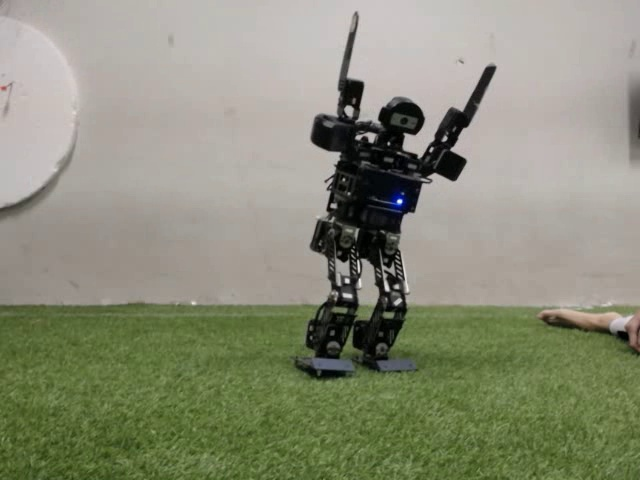

In [16]:
html = coco_dataset.display_image(2281)
IPython.display.HTML(html)

In [ ]:
video_input = ['output3', 'output3_day2', 'output4_day2', 'output5_day2']
video_output = ['output-result3', 'output-result3_day2', 'output-result4_day2', 'output-result5_day2']

## Get Result from Video

In [38]:
import cv2
from SimplePoseNet import SimplePoseNet
   
# Create an object to read 
# from camera
video = cv2.VideoCapture('video/output5_day2.mp4')
   
# We need to check if camera
# is opened previously or not
if (video.isOpened() == False): 
    print("Error reading video file")
  
# We need to set resolutions.
# so, convert them from float to integer.
frame_width = int(video.get(3))
frame_height = int(video.get(4))
   
size = (frame_width, frame_height)
   
# Below VideoWriter object will create
# a frame of above defined The output 
# is stored in 'filename.avi' file.
result = cv2.VideoWriter('video/result/output-result5_day2.mp4', 
                         cv2.VideoWriter_fourcc(*'mp4v'),
                         10, size)

model = SimplePoseNet(nof_joints=6, checkpoint_path='ichiro_training_new/checkpoint.pth')
    
while(video.isOpened()):
    ret, frame = video.read()
  
    if ret == True: 
        keypoint_coordinat = model.predict(frame)
        
        for i, item in enumerate(keypoint_coordinat):
            text = ''
            if i == 0: text = 'Head'
            elif i == 1: text = 'Trunk'
            elif i == 2: text = 'RH'
            elif i == 3: text = 'LH'
            elif i == 4: text = 'RF'
            elif i == 5: text = 'LF'

            # for item in items:
            frame = cv2.circle(frame, item, 5, (255,0,0), -1)
            frame = cv2.putText(frame, " " + text, item, cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1, cv2.LINE_AA)

        # Write the frame into the
        # file 'filename.avi'
        result.write(frame)
    # Break the loop
    else:
        break
  
# When everything done, release 
# the video capture and video 
# write objects
video.release()
result.release()
   
print("The video was successfully saved")

The video was successfully saved


In [28]:
# import torch
# import cv2
# from torchvision import transforms
# import time
# from src.models.posenet import PoseNet 

# model = PoseNet((5, 6 + 1), 3, 'resnet18', True)
# # device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')


# convert_tensor = transforms.ToTensor()
# start_time = time.time()

# image = cv2.imread('dataset/hrp/images/output_0.jpg', cv2.IMREAD_COLOR)
# image = convert_tensor(image)
# # add dimension
# image = image[None, :, :, :]
# image.size()
# image = image.to(device)
# print("--- %s seconds ---" % (time.time() - start_time))

# outputs = model(image)
# print("--- %s seconds ---" % (time.time() - start_time))

In [1]:
!python src/main.py --config experiments/train_ichiro_kidsize_2.yaml --output_dir ichiro_kidsize_2 --dataset_path dataset/hrp/

BATCH_SIZE: 16
DATASET:
  FLIP: 0.5
  INPUT_SIZE: [384, 384]
  MAX_NUM_DETECTIONS: 10
  MEAN: (0.485, 0.456, 0.406)
  NUM_KEYPOINTS: 6
  NUM_LIMBS: 5
  OUTPUT_SIZE: [192, 192]
  ROTATION: 40
  SCALE: [0.5, 1.5]
  SIGMA: 2.0
  STD: (0.229, 0.224, 0.225)
  TEST: val_kidsize_2
  TRAIN: train_kidsize_2
  TRANSLATE: 0.4
DEVICE: cuda
LOSS:
  USE_WEIGHT: True
MODE: hm
MODEL:
  BACKBONE: resnet18
  FINAL_KERNEL: 3
  NUM_SCALES: 2
  PRETRAINED: True
NUM_EPOCHS: 50
NUM_WORKERS: 2
PIN_MEMORY: False
PRINT_FREQ: 100
SEED: 42
TEST:
  DETECTION_THRESHOLD: 0.1
  KEEP_RATIO: True
  LIMB:
    CONNECTION_RATIO: 0.8
    CONNECTION_TOLERANCE: 0.7
    DELETE_SHARED_PARTS: False
    IGNORE_FEW_PARTS: False
    LENGTH_RATE: 16
    MIN_MEAN_SCORE: 0.2
    MIN_NUM_CONNECTED_PARTS: 3
    NUM_MIDPOINTS: 20
    THRESHOLD: 0.05
  NMS_KERNEL: 3
  PROJECT: True
TRAIN:
  LR: 0.0001
  LR_FACTOR: 0.0
  LR_STEPS: []
  MOMENTUM: 0.0
  OPTIMIZER: adamw
  WD: 0.0001
/usr/local/lib/python3.10/dist-packages/torchvision/models

In [19]:
!python src/main.py --eval --config experiments/train_ichiro_kidsize_2.yaml --dataset_path dataset/hrp/ --checkpoint ichiro_kidsize/checkpoint.pth

BATCH_SIZE: 16
DATASET:
  FLIP: 0.5
  INPUT_SIZE: [384, 384]
  MAX_NUM_DETECTIONS: 10
  MEAN: (0.485, 0.456, 0.406)
  NUM_KEYPOINTS: 6
  NUM_LIMBS: 5
  OUTPUT_SIZE: [192, 192]
  ROTATION: 40
  SCALE: [0.5, 1.5]
  SIGMA: 2.0
  STD: (0.229, 0.224, 0.225)
  TEST: val_kidsize_2
  TRAIN: train_kidsize_2
  TRANSLATE: 0.4
DEVICE: cuda
LOSS:
  USE_WEIGHT: True
MODE: hm
MODEL:
  BACKBONE: resnet18
  FINAL_KERNEL: 3
  NUM_SCALES: 2
  PRETRAINED: True
NUM_EPOCHS: 100
NUM_WORKERS: 2
PIN_MEMORY: False
PRINT_FREQ: 100
SEED: 42
TEST:
  DETECTION_THRESHOLD: 0.1
  KEEP_RATIO: True
  LIMB:
    CONNECTION_RATIO: 0.8
    CONNECTION_TOLERANCE: 0.7
    DELETE_SHARED_PARTS: False
    IGNORE_FEW_PARTS: False
    LENGTH_RATE: 16
    MIN_MEAN_SCORE: 0.2
    MIN_NUM_CONNECTED_PARTS: 3
    NUM_MIDPOINTS: 20
    THRESHOLD: 0.05
  NMS_KERNEL: 3
  PROJECT: True
TRAIN:
  LR: 0.0001
  LR_FACTOR: 0.0
  LR_STEPS: []
  MOMENTUM: 0.0
  OPTIMIZER: adamw
  WD: 0.0001
/usr/local/lib/python3.10/dist-packages/torchvision/model

In [8]:
import time
from SimplePoseNet import SimplePoseNet

model = SimplePoseNet(nof_joints=6, checkpoint_path='weights/checkpoint.pth')
start_time = time.time()
keypoint_coordinat = model.predict('dataset/hrp/images/1079.jpg')

print("--- %s seconds ---" % (time.time() - start_time))
keypoint_coordinat

--- 0.08856415748596191 seconds ---


[(288, 4), (324, 192), (308, 400), (308, 400), (360, 344), (376, 344)]

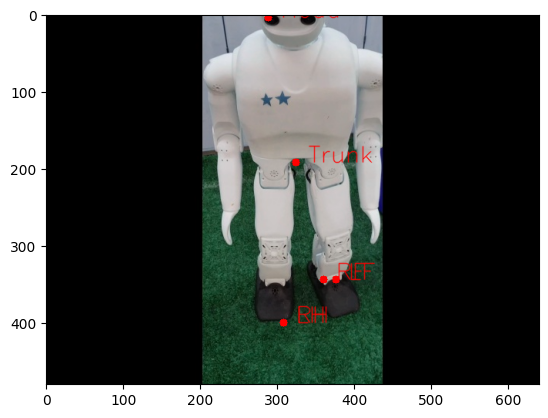

In [9]:
import cv2
import matplotlib.pyplot as plt


image_copy1 = cv2.imread('dataset/hrp/images/1079.jpg', cv2.IMREAD_COLOR)

for i, item in enumerate(keypoint_coordinat):
    text = ''
    if i == 0: text = 'Head'
    elif i == 1: text = 'Trunk'
    elif i == 2: text = 'RH'
    elif i == 3: text = 'LH'
    elif i == 4: text = 'RF'
    elif i == 5: text = 'LF'
    
    # for item in items:
    image_copy1 = cv2.circle(image_copy1, item, 5, (255,0,0), -1)
    image_copy1 = cv2.putText(image_copy1, " " + text, item, cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1, cv2.LINE_AA)
plt.imshow(image_copy1)